### Load dataset and shuffle

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/movielens/ml-small/ratings.csv')
df = df.sample(df.shape[0])
print(df.shape)
display(df.head())
print(len(df['movieId'].unique()))
print(len(df['userId'].unique()))

(100836, 4)


,userId,movieId,rating,timestamp
29501,202,1203,4.0,974912395
58415,381,8644,4.0,1167542569
59741,387,3444,2.5,1145149679
59305,387,586,2.0,1095120880
773,6,489,3.0,845554505


9724
610


### Split the dataset into train and test

In [2]:
X_train, X_test, y_train, y_test = train_test_split(df[['userId', 'movieId', 'rating']], df['rating'].values.reshape(-1,1), test_size = 0.2, random_state = 0)



### Some implementation on the training set
#### transform the dataframe struction: each row represents a unique userId and each column is a movieId, the values are ratings
so it's going to be 610 x 8974 table

In [3]:
print(len(X_train['movieId'].unique()))
print(len(X_train['userId'].unique()))

8978
610


dropdup by userId and movieId, users can't comment on the same movie twice

In [4]:
X_train = X_train.drop_duplicates(['movieId', 'userId'])
X_train.shape

(80668, 3)

In [5]:
X_train_new = pd.pivot_table(X_train,index=['userId'],columns=['movieId'],values=['rating'])
X_train_new

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          4.0    NaN    4.0    NaN    NaN    4.0    NaN    NaN    NaN    NaN   
2          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5          4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
606        NaN    NaN    NaN    NaN    NaN    NaN    2.5    NaN    NaN    NaN   
607        4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
608        2.5    NaN    2.0    NaN    NaN    NaN    NaN    NaN    NaN    4.0   
609        3.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    4.0   
610        5.0    NaN    NaN    NaN    NaN    5.0    NaN    NaN    NaN    NaN   

         ...                                                                 \
movieId  ... 190213 190219 190221 191005 193565 193567 193573 193579 193583   
userId   ...                                                                  
1        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
606      ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
607      ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
608      ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
609      ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
610      ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                
movieId 193585  
userId          
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  
...        ...  
606        NaN  
607        NaN  
608        NaN  
609        NaN  
610        NaN  

[610 rows x 8978 columns]

Drop empty rows and fill na with 0

In [6]:
X_train_new = X_train_new.dropna(subset=list(X_train_new),how='all',axis=0).fillna(0)
X_train_new.shape

(610, 8978)

#### generate the similarity matrix of users, using cosine similarity.

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

user_sim_mat = cosine_similarity(X_train_new)
print(user_sim_mat.shape)
print(user_sim_mat)

(610, 610)
[[1.         0.03569221 0.0266285  ... 0.24503497 0.09137611 0.11097099]
 [0.03569221 1.         0.         ... 0.03863475 0.         0.07063505]
 [0.0266285  0.         1.         ... 0.01977939 0.         0.02883332]
 ...
 [0.24503497 0.03863475 0.01977939 ... 1.         0.11385489 0.26756805]
 [0.09137611 0.         0.         ... 0.11385489 1.         0.04832448]
 [0.11097099 0.07063505 0.02883332 ... 0.26756805 0.04832448 1.        ]]


A function that returns his most similar N users as long as the similarity is greater than threhold

In [15]:
def findSimilariUsers(userId, user_sim_mat, list_index, N, sim_threhold):
    if userId not in list_index:
        print('This is a new user, can not calculate similarity')
        return None
    userId = int(userId)
    index = list_index.index(userId)
    list_similarity = user_sim_mat[index]
    # ascending order of userId index and get the last N numbers except for the last one, which is itself
    index_sorted = np.argsort(list_similarity)[-(N+1):-1]
#     index_sorted = [item for item in index_sorted if abs(list_similarity[item]) >= sim_threhold]
    return index_sorted
    

In [16]:
findSimilariUsers(1, user_sim_mat, list(X_train_new.index), 3, 0.1)

array([ 63, 329, 265])

#### Try to predict on X_test

In [17]:
predicts = []
for index, row in X_test.iterrows():
    userId, movieId, rating = row['userId'], row['movieId'], row['rating']
    sim_users = findSimilariUsers(userId, user_sim_mat, list(X_train_new.index), 10, 0)
    # no users are similar enough
    if len(sim_users) == 0:
        predict = -1
    else:
        # searching similar users from the X_train(before transformed)
        df_sim = X_train[(X_train['userId'].isin(sim_users))&(X_train['movieId']==movieId)]
        if df_sim.shape[0]!=0:
            # use the average ratings for the similar users as prediction
            predict = df_sim['rating'].mean()
        else:
            predict = -1
    predicts.append(predict)

X_test['predict'] = predicts

#### Evaluation
the recommendation is a little bit low, but the error seems ok because most the the absolute errors are within 1

In [18]:
print('size of X_test:' ,X_test.shape[0])
df_test_rec = X_test[X_test['predict']!=-1]
print('number of effective recommendation:',df_test_rec.shape[0])
print('recommendation rate is:', df_test_rec.shape[0]/X_test.shape[0])

y_pred = df_test_rec['predict'].values.reshape(-1,1)
y_test = df_test_rec['rating'].values.reshape(-1,1)
print("Residual sum of squares (RSS): %.2f" % sum((y_pred - y_test) ** 2))
print("Mean absolute error (MAE): %.2f" % np.mean(abs(y_pred - y_test)))
print("Mean square error (MSE): %.2f" % np.mean((y_pred - y_test) ** 2))
print("Root mean square error (RMSE): %.2f" % np.sqrt(np.mean((y_pred - y_test) ** 2)))


size of X_test: 20168
number of effective recommendation: 8416
recommendation rate is: 0.4172947243157477
Residual sum of squares (RSS): 11859.63
Mean absolute error (MAE): 0.91
Mean square error (MSE): 1.41
Root mean square error (RMSE): 1.19


<AxesSubplot:>

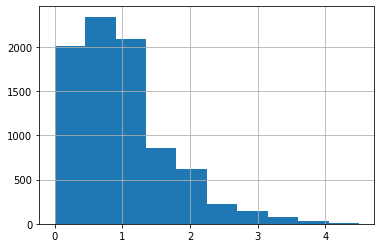

In [19]:
abs(df_test_rec['rating']-df_test_rec['predict']).hist()